In [ ]:
! pip install pyswarm

  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=adf06ad16fb4b7be9c588b45489eb34e7563926cf2fe87bed7417fa144c4cf5b
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from pyswarm import pso
from collections import Counter

# Load dataset
iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
class KNNFromScratch:
    def __init__(self, k=3, metric='euclidean'):
        self.k = k
        self.metric = metric

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        predictions = [self._predict(x) for x in X_test]
        return np.array(predictions)

    def _predict(self, x):
        distances = [self._distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

    def _distance(self, a, b):
        if self.metric == 'euclidean':
            return np.sqrt(np.sum((a - b) ** 2))
        elif self.metric == 'manhattan':
            return np.sum(np.abs(a - b))
        elif self.metric == 'minkowski':
            p = 3
            return np.sum(np.abs(a - b) ** p) ** (1 / p)
        else:
            raise ValueError("Unsupported metric")

In [ ]:

def objective_function(params):
    k = int(params[0])
    if k < 1:
        k = 1
    metric_index = int(params[1])
    metrics = ['euclidean', 'manhattan', 'minkowski']
    metric = metrics[metric_index % len(metrics)]

    selected_features = [i for i, p in enumerate(params[2:]) if round(p) == 1]
    if len(selected_features) == 0:
        return 1.0

    X_train_selected = X_train[:, selected_features]
    X_test_selected = X_test[:, selected_features]

    model = KNNFromScratch(k=k, metric=metric)
    model.fit(X_train_selected, y_train)
    predictions = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, predictions)

    return 1 - accuracy


In [ ]:
n_features = X.shape[1]

# Bounds for k, metric index, and feature selection (0 or 1 for each feature)
lb = [1, 0] + [0]*n_features
ub = [30, 2] + [1]*n_features

# Run PSO for feature selection
best_params, best_score = pso(objective_function, lb, ub, swarmsize=50, maxiter=100)

print('Best Parameters:', best_params)
print('Best Score:', 1 - best_score)

k_opt = int(round(best_params[0]))
metric_index_opt = int(round(best_params[1]))
metrics = ['euclidean', 'manhattan', 'minkowski']
metric_opt = metrics[metric_index_opt]
selected_features = [i for i, p in enumerate(best_params[2:]) if round(p) == 1]

print('Selected Features:', selected_features)

Stopping search: maximum iterations reached --> 100
Best Parameters: [23.53215137  0.33963021  0.80532019  0.98200729  0.5793569   0.92869813]
Best Score: 1.0
Selected Features: [0, 1, 2, 3]


In [ ]:
# Apply LDA for feature reduction
lda = LDA(n_components=2)  # Reduce to 2 components for visualization
X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]

X_train_reduced = lda.fit_transform(X_train_selected, y_train)
X_test_reduced = lda.transform(X_test_selected)

# Train k-NN with selected and reduced features
model = KNNFromScratch(k=k_opt, metric=metric_opt)
model.fit(X_train_reduced, y_train)
predictions = model.predict(X_test_reduced)
accuracy = accuracy_score(y_test, predictions)

print('Final Model Accuracy:', accuracy)

Final Model Accuracy: 1.0


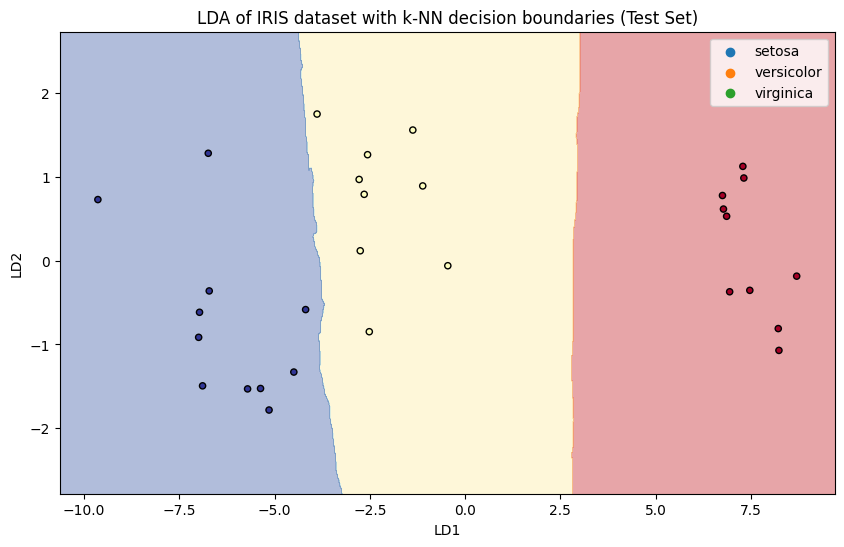

In [ ]:
# Plot decision boundaries on the test set

x_min, x_max = X_test_reduced[:, 0].min() - 1, X_test_reduced[:, 0].max() + 1
y_min, y_max = X_test_reduced[:, 1].min() - 1, X_test_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)
plt.scatter(X_test_reduced[:, 0], X_test_reduced[:, 1], c=y_test, edgecolor='k', s=20, cmap=plt.cm.RdYlBu)

for i, target_name in enumerate(iris.target_names):
    plt.scatter([], [], label=target_name)

plt.title('LDA of IRIS dataset with k-NN decision boundaries (Test Set)')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend()
plt.show()
